In [149]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from keras import backend as K
color = sns.color_palette()
%matplotlib inline


# VGG16

In [150]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)

# Make the augmentation sequence deterministic
aug.seed(111)

In [151]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [152]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.*g')
#normal_cases.extend('*.png')
#normal_cases.extend('*.jpg')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')
#pneumonia_cases = pneumonia_cases_dir.glob('*.jpg')
#pneumonia_cases = pneumonia_cases_dir.glob('*.png')



In [153]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.*g')
#normal_cases.extend('*.png')
#normal_cases.extend('*.jpg')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')
#pneumonia_cases = pneumonia_cases_dir.glob('*.jpg')
#pneumonia_cases = pneumonia_cases_dir.glob('*.png')

print(normal_cases)
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)
# How the dataframe looks like?
train_data.head()

<generator object Path.glob at 0x00000263923CD048>


,image,label
0,chest_xray\train\PNEUMONIA\BACTERIA-9361638-00...,1
1,chest_xray\train\PNEUMONIA\BACTERIA-7075658-00...,1
2,chest_xray\train\PNEUMONIA\VIRUS-9543809-0002....,1
3,chest_xray\train\PNEUMONIA\BACTERIA-1213217-00...,1
4,chest_xray\train\PNEUMONIA\BACTERIA-3690865-00...,1


In [154]:
# Get the path to the sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.*g')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [155]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=40), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [156]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [157]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.3, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.2, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [158]:
model =  build_model()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [159]:
opt = RMSprop(lr=0.0001, decay=1e-6)
#opt = Adam(lr=0.0001, decay=1e-5)
#opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=15)
chkpt = ModelCheckpoint(filepath='best_modelvgg.hdf5', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [160]:
batch_size = 16
nb_epochs = 30

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 327 and 624


In [161]:


def showGraph(Histroy, epochs):
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), Histroy.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), Histroy.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), Histroy.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), Histroy.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [162]:
# Load the model weights
model.load_weights("SOTA_VGG_diff_structure_higher_data_aug_BEST.h5")


In [163]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.*g')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [164]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 34s 54ms/step
Loss on test set:  0.2113733533769846
Accuracy on test set:  0.9102563858032227


In [165]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')
#print(preds)
#print(orig)

# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig = np.argmax(test_labels, axis=-1)

#print(orig)
#print(preds)


<Figure size 432x288 with 0 Axes>

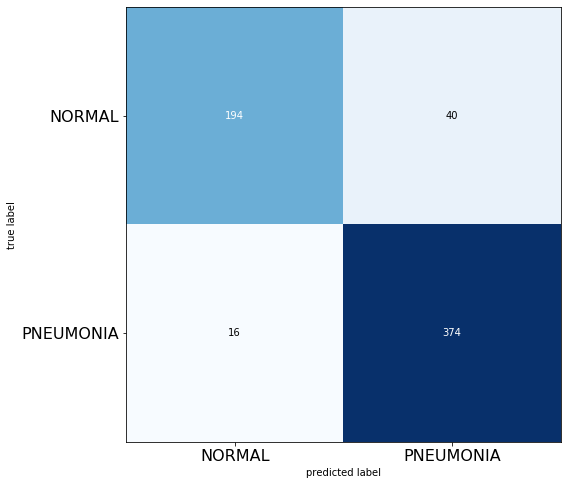

In [166]:
# Get the confusion matrix
cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()

In [167]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))




def evaluate_error(preds, orig):
    #pred = model.predict(x_test, batch_size = 32)
    #pred = np.argmax(pred, axis=1)
    #pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(preds, orig)) / orig.shape[0]   
 
    print("Error score of the model is {:.2f}".format(error))
    
evaluate_error(preds, orig)

Accuracy: 91.03
Recall: 95.90
Precision: 90.34
F1 score: 93.03
Error score of the model is 0.09


In [168]:
vgg = model

# Inception

In [169]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.common.set_image_dim_ordering('th')
#keras.backend.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier





In [170]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="inception_transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224,3))


x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

base_model.load_weights("inception_v3_weights.h5")

model = Model(inputs=base_model.input, outputs=predictions)
opt = RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

C:\Users\StudyEasy\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [171]:
model = Model(inputs=base_model.input, outputs=predictions)

In [172]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [173]:
model.load_weights("InceptionSOTATake2UseThis.h5")

<Figure size 432x288 with 0 Axes>

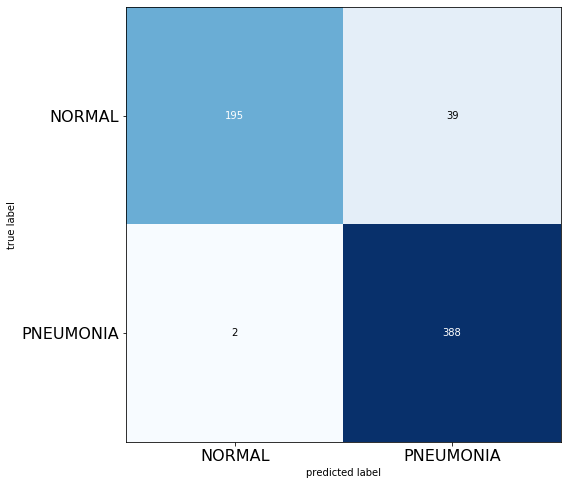

Accuracy: 93.43
Recall: 99.49
Precision: 90.87
F1 score: 94.98


In [174]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')
#print(preds)
#print(orig)

# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig = np.argmax(test_labels, axis=-1)

cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()

# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))

In [175]:
inception = model

# ResNet

In [176]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.common.set_image_dim_ordering('th')
#keras.backend.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)


# Make the augmentation sequence deterministic
aug.seed(111)

# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [177]:
# Get the path to the sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.*g')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [178]:

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order



In [179]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [180]:
from keras.applications.resnet50 import ResNet50, preprocess_input
# Get fine-tuning/transfer-learning model
def get_fine_tuning_model(base_model, top_model, inputs, learning_type):
    if learning_type=='transfer_learning':
        print("Doing transfer learning")
        K.set_learning_phase(0)
        base_model.trainable = False
        features = base_model(inputs)
        outputs = top_model(features)
    else:
        print("Doing fine-tuning")
        base_model.trainable = True
        features = base_model(inputs)
        outputs = top_model(features)
    return Model(inputs, outputs)

# Get the base model
base_model = ResNet50(input_shape=(224, 224, 3), 
                       weights='imagenet', 
                       include_top=False, 
                       pooling='avg')

# Define a top model: extra layers that we are going to add on top of our base network
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Dense(50, activation='relu', name='fc1')(feature_inputs)
x = BatchNormalization()(x)
#x = Dropout(0.3,name='drop')(x)
outputs = Dense(2, activation='softmax', name='fc2')(x)
top_model = Model(feature_inputs, outputs, name='top_model')

# get model for tranfser learning
inputs = Input(shape=(224, 224, 3))
model = get_fine_tuning_model(base_model, top_model, inputs, "transfer_learning")

Doing transfer learning


In [181]:
batch_size = 16
nb_epochs = 50

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size
opt = RMSprop(lr=0.0001, decay=1e-6)
print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))
chkpt = ModelCheckpoint(filepath='ResNetFULL_NEW.h5', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

Number of training and validation steps: 327 and 624


In [182]:
# Load the model weights
model.load_weights("ResNetSOTA_NEw.h5")

In [183]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.*g')
pneumonia_cases = pneumonia_cases_dir.glob('*.*g')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [184]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 35s 56ms/step
Loss on test set:  0.2734517393968044
Accuracy on test set:  0.8862179517745972


In [185]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')
#print(preds)
#print(orig)

# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig = np.argmax(test_labels, axis=-1)

#print(orig)
#print(preds)

<Figure size 432x288 with 0 Axes>

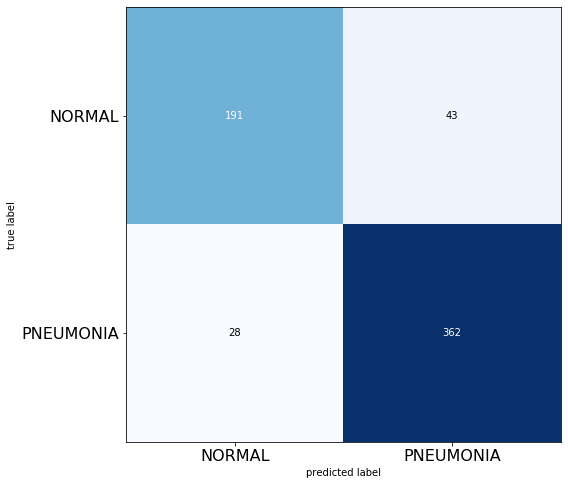

In [186]:
# Get the confusion matrix
cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()

In [187]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)


precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))

Accuracy: 88.62
Recall: 92.82
Precision: 89.38
F1 score: 91.07


In [188]:
resnet = model

# Ensemble

# VGG + ResNet + Inception

In [189]:

P1 = vgg.predict(test_data, batch_size=16)
P2 = inception.predict(test_data, batch_size=16)
P3 = resnet.predict(test_data, batch_size=16)

PE = (np.array(P1) + np.array(P2) + np.array(P3)) / 3.0

PE = np.squeeze((PE > 0.5).astype('int'))
PE = np.argmax(PE, axis=-1)

orig = np.argmax(test_labels, axis=-1)


#PE,orig




(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

<Figure size 432x288 with 0 Axes>

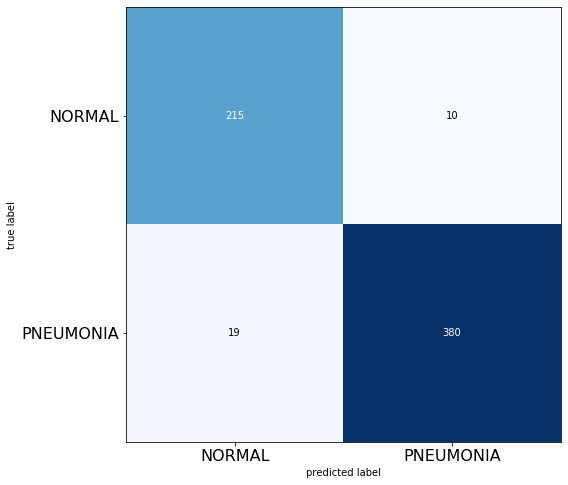

Accuracy: 95.35
Recall: 95.24
Precision: 97.44
F1 score: 96.32


In [190]:
cm  = confusion_matrix(PE, orig)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()


# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))


# VGG + ResNet

In [191]:
P1 = vgg.predict(test_data, batch_size=16)
#P2 = inception.predict(test_data, batch_size=16)
P3 = resnet.predict(test_data, batch_size=16)

PE = (np.array(P1) + np.array(P3)) / 2.0

PE = np.squeeze((PE > 0.5).astype('int'))
PE = np.argmax(PE, axis=-1)

#orig = np.argmax(test_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

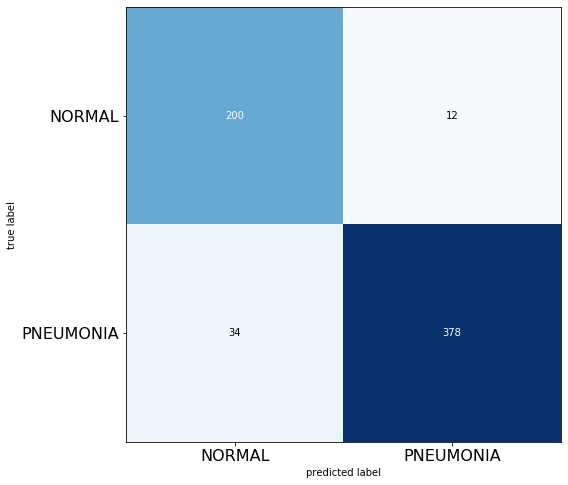

Accuracy: 92.63
Recall: 91.75
Precision: 96.92
F1 score: 94.26


In [192]:
cm  = confusion_matrix(PE, orig)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()


# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))

# VGG + Inception

In [193]:
P1 = vgg.predict(test_data, batch_size=16)
P2 = inception.predict(test_data, batch_size=16)
#P3 = resnet.predict(test_data, batch_size=16)

PE = (np.array(P1) + np.array(P2)) / 2.0

PE = np.squeeze((PE > 0.5).astype('int'))
PE = np.argmax(PE, axis=-1)

#orig = np.argmax(test_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

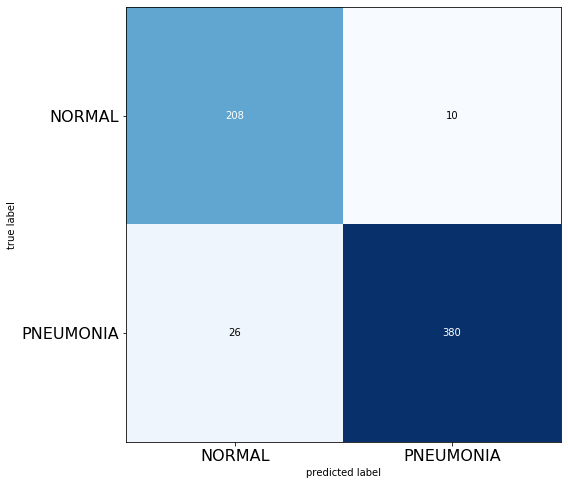

Accuracy: 94.23
Recall: 93.60
Precision: 97.44
F1 score: 95.48


In [194]:
cm  = confusion_matrix(PE, orig)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()


# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))

# ResNet + Inception

In [195]:
#P1 = vgg.predict(test_data, batch_size=16)
P2 = inception.predict(test_data, batch_size=16)
P3 = resnet.predict(test_data, batch_size=16)

PE = ( np.array(P2) + np.array(P3)) / 2.0

PE = np.squeeze((PE > 0.5).astype('int'))
PE = np.argmax(PE, axis=-1)

#orig = np.argmax(test_labels, axis=-1)

<Figure size 432x288 with 0 Axes>

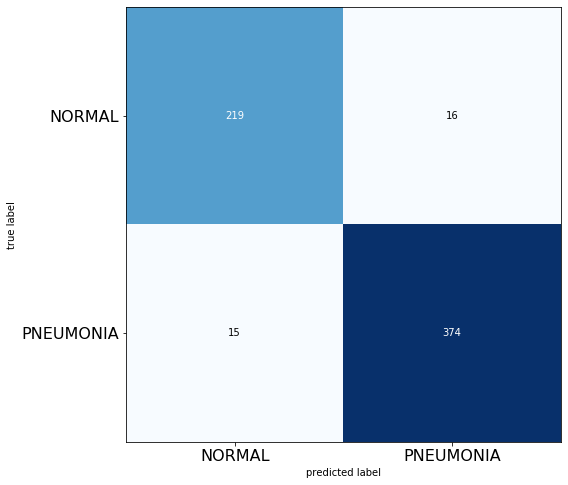

Accuracy: 95.03
Recall: 96.14
Precision: 95.90
F1 score: 96.02


In [196]:
cm  = confusion_matrix(PE, orig)
plt.figure()
plot_confusion_matrix
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plt.show()


# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1Score = 2 * ((precision*recall)/(precision+recall))
accuracy = (tn + tp)/(tn + fp + fn + tp)
print("Accuracy: {:.2f}".format(accuracy*100))
print("Recall: {:.2f}".format(recall*100))
print("Precision: {:.2f}".format(precision*100))
print("F1 score: {:.2f}".format(F1Score*100))